<a href="https://colab.research.google.com/github/chaos1231107/pytorch-study/blob/main/pytorch_tutorial2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/main/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)

In [ ]:
import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

(50000, 784)


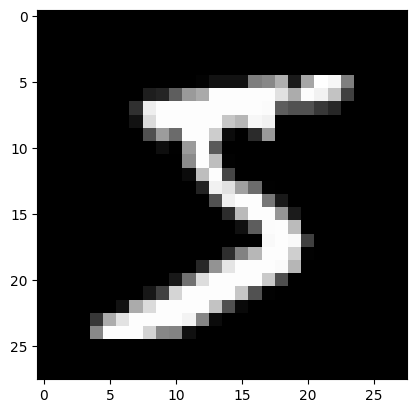

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(x_train[0].reshape((28,28)),cmap='gray')

try:
    import google.colab
except ImportError:
    plt.show()
print(x_train.shape)

In [ ]:
import torch

x_train,y_train, x_valid, y_valid = map(torch.tensor, (x_train,y_train, x_valid, y_valid)
)

n, c = x_train.shape
print(x_train, y_train)
print(x_train.shape)
print(y_train.min(), y_train.max())

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]) tensor([5, 0, 4,  ..., 8, 4, 8])
torch.Size([50000, 784])
tensor(0) tensor(9)


In [ ]:
import math

weights = torch.randn(784,10) / math.sqrt(784)
weights.requires_grad_()
bias = torch.zeros(10, requires_grad=True)

In [ ]:
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

def model(xb):
    return log_softmax(xb @ weights + bias)

In [ ]:
bs = 64
xb = x_train[0:bs]
preds = model(xb)
preds[0], preds.shape
print(preds[0], preds.shape)

tensor([-2.4299, -2.4315, -2.2769, -2.2642, -2.2997, -1.9770, -2.5964, -2.0768,
        -2.4539, -2.3759], grad_fn=<SelectBackward0>) torch.Size([64, 10])


In [ ]:
def loss_func(input,target):
    return -input[range(target.shape[0]), target].mean()


In [ ]:
yb = y_train[0:bs]
print(loss_func(preds,yb))

tensor(2.3145, grad_fn=<NegBackward0>)


In [ ]:
def accuracy(out,yb):
    preds = torch.argmax(out,dim=1)
    return (preds == yb).float().mean()

In [ ]:
print(accuracy(preds,yb))

tensor(0.1250)


In [ ]:
from IPython.core.debugger import set_trace

lr = 0.5
epochs = 2
for epoch in range(epochs):
    for i in range((n-1) // bs + 1):

        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        preds = model(xb)
        loss = loss_func(preds,yb)

        loss.backward()
        with torch.no_grad():
            weights -= weights.grad * lr
            bias -= bias.grad * lr
            weights.grad.zero_()
            bias.grad.zero_()
print(loss_func(model(xb),yb))

tensor(0.0777, grad_fn=<NegBackward0>)


In [ ]:
import torch.nn.functional as F
loss_func = F.cross_entropy

def model(xb):
    return  xb @ weights + bias
print(loss_func(model(xb),yb), accuracy(model(xb),yb))

tensor(0.0777, grad_fn=<NllLossBackward0>) tensor(1.)


In [ ]:
from torch import nn

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(784,10) / math.sqrt(784))
        self.bias = nn.Parameter(torch.zeros(10))

    def forward(self,xb):
        return xb @ self.weights + self.bias

model = Mnist_Logistic()
print(loss_func(model(xb),yb))

tensor(2.2928, grad_fn=<NllLossBackward0>)


In [ ]:
def fit():
    for epoch in range(epochs):
        for i in range((n-1) // bs + 1):
            start_i = i * bs
            end_i = start_i + bs
            xb = x_train[start_i:end_i]
            yb = y_train[start_i:end_i]
            preds = model(xb)
            loss = loss_func(preds,yb)

            loss.backward()
            with torch.no_grad():
                for p in model.parameters():
                    p -= p.grad * lr
                model.zero_grad()
fit()

print(loss_func(model(xb),yb))

tensor(0.0815, grad_fn=<NllLossBackward0>)


In [ ]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784,10)
    def forward(self,xb):
        return self.lin(xb)

model = Mnist_Logistic()
fit()
print(loss_func(model(xb),yb))

tensor(0.0811, grad_fn=<NllLossBackward0>)


In [ ]:
from torch import optim

def get_model():
    model = Mnist_Logistic()
    return model,optim.SGD(model.parameters(),lr=lr)

model, opt = get_model()
print(loss_func(model(xb),yb))

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        start_i = i * bs
        end_i = start_i + bs
        xb = x_train[start_i:end_i]
        yb = y_train[start_i:end_i]
        pred = model(xb)
        loss = loss_func(model(xb),yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb),yb))

tensor(2.2998, grad_fn=<NllLossBackward0>)
tensor(0.0824, grad_fn=<NllLossBackward0>)


In [ ]:
from torch.utils.data import TensorDataset

train_ds = TensorDataset(x_train, y_train)
xb = x_train[start_i:end_i]
yb = y_train[start_i:end_i]

xb,yb = train_ds[i*bs : i*bs+bs]

model,opt = get_model()

for epoch in range(epochs):
    for i in range((n-1) // bs + 1):
        xb,yb = train_ds[i*bs:i*bs+bs]
        pred = model(xb)
        loss = loss_func(pred,yb)

        loss.backward()
        opt.step()
        opt.zero_grad()

print(loss_func(model(xb),yb))

tensor(0.0810, grad_fn=<NllLossBackward0>)


In [ ]:
from torch.utils.data import DataLoader

train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs)

for epoch in range(epochs):
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred,yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
print(loss_func(model(xb),yb))

tensor(0.0654, grad_fn=<NllLossBackward0>)


In [ ]:
train_ds = TensorDataset(x_train, y_train)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)

valid_ds = TensorDataset(x_valid, y_valid)
valid_dl = DataLoader(valid_ds, batch_size=bs*2)

model,opt = get_model()

for epoch in range(epochs):
    model.train()
    for xb,yb in train_dl:
        pred = model(xb)
        loss = loss_func(pred,yb)

        loss.backward()
        opt.step()
        opt.zero_grad()
    model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_func(model(xb),yb) for xb,yb in valid_dl)

    print(epoch, valid_loss / len(valid_dl))


0 tensor(0.3474)
1 tensor(0.2795)


In [ ]:
import numpy as np

def loss_batch(model,loss_func,xb,yb,opt=None):
    loss = loss_func(model(xb),yb)

    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(xb)

def fit(epochs,modes,loss_func,opt,train_dl,valid_dl):
    for epoch in range(epochs):
        for xb,yb in train_dl:
            loss_batch(model, loss_func, xb, yb, opt)

        model.eval()
        with torch.no_grad():
            losses, nums = zip(
                *[loss_batch(model,loss_func,xb,yb) for xb,yb in valid_dl] #미니배치의 크기와 샘플수를 튜플로 묶어서 리스트생성, 언패킹
            )
        val_loss = np.sum(np.multiply(losses,nums)) / np.sum(nums)

        print(epoch, val_loss)

def get_data(train_ds,valid_ds,bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs*2),
    )

train_dl, valid_dl = get_data(train_ds, valid_ds, bs)
model,opt = get_model()
fit(epochs, model,loss_func, opt, train_dl, valid_dl)


0 0.34745807973146436
1 0.30785661758184435


In [ ]:
class Mnist_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(16,16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16,10, kernel_size=3, stride=2, padding=1)

    def forward(self,xb):
        xb = xb.view(-1,1,28,28)
        xb = F.relu(self.conv1(xb))
        xb = F.relu(self.conv2(xb))
        xb = F.relu(self.conv3(xb))
        xb = F.avg_pool2d(xb,4)
        return xb.view(-1, xb.size(1))
    lr = 0.1

In [ ]:
model = Mnist_CNN()
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

fit(epochs, model, loss_func, opt, train_dl, valid_dl)

0 0.7455485592842102
1 0.6816397270202637


In [ ]:
class Lambda(nn.Module):
    def __init__(self,func):
        super().__init__()
        self.func = func

    def forward(self,x):
        return self.func(x)

    def preprocess(x):
        return x.view(-1.1,28,28)

In [ ]:
model = nn.Sequential(
    Lambda(preprocess),


)

NameError: ignored